---
title: Sparse Observations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, SWOT
---

In [69]:
import os

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [70]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/

gf_mod_ssh_daily.nc       gf_obs_nadir.nc.dvc       natl_mod_ssh_daily.nc.dvc
gf_mod_ssh_daily.nc.dvc   gf_obs_nadirswot.nc       natl_mod_sst.nc.dvc
gf_mod_sst.nc             gf_obs_nadirswot.nc.dvc   natl_obs_nadir.nc.dvc
gf_mod_sst.nc.dvc         gf_obs_swot.nc            natl_obs_nadirswot.nc.dvc
gf_obs_nadir.nc           gf_obs_swot.nc.dvc


In [71]:
from typing import Optional, Union
import numpy as np
import xarray as xr
import pandas as pd
def time_rescale(
    ds: xr.Dataset,
    freq_dt: int = 1,
    freq_unit: str = "seconds",
    t0: Optional[Union[str, np.datetime64]] = None,
) -> xr.Dataset:
    """Rescales time dimensions of np.datetim64 to an output frequency.

    t' = (t - t_0) / dt

    Args:
        ds (xr.Dataset): the xr.Dataset with a time dimensions
        freq_dt (int): the frequency of the temporal coordinate
        freq_unit (str): the unit for the time frequency parameter
        t0 (datetime64, str): the starting point. Optional. If none, assumes the
            minimum value of the time coordinate

    Returns:
        ds (xr.Dataset): the xr.Dataset with the rescaled time dimensions in the
            freq_unit.
    """

    ds = ds.copy()

    if t0 is None:
        t0 = ds["time"].min()

    if isinstance(t0, str):
        t0 = np.datetime64(t0)

    ds["time"] = ((ds["time"] - t0) / pd.to_timedelta(freq_dt, unit=freq_unit)).astype(
        np.float32
    )

    return ds


In [72]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid

gf_mod_ssh_daily.nc       gf_obs_nadir.nc.dvc       natl_mod_ssh_daily.nc.dvc
gf_mod_ssh_daily.nc.dvc   gf_obs_nadirswot.nc       natl_mod_sst.nc.dvc
gf_mod_sst.nc             gf_obs_nadirswot.nc.dvc   natl_obs_nadir.nc.dvc
gf_mod_sst.nc.dvc         gf_obs_swot.nc            natl_obs_nadirswot.nc.dvc
gf_obs_nadir.nc           gf_obs_swot.nc.dvc


In [76]:
import xarray as xr
# from oceanbench._src.geoprocessing.temporal import time_rescale

# True Dataset
xrds_natl60 = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
xrds_natl60 = xrds_natl60.sel(time=slice("2012-10-22","2012-10-24"))
xrds_natl60 = time_rescale(xrds_natl60, freq_dt=1, freq_unit="seconds", t0=None)


In [77]:
# Observation Dataset
xrds_obs = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_obs_nadir.nc")
xrds_obs = xrds_obs.sel(time=slice("2012-10-22","2012-10-24"))
xrds_obs = time_rescale(xrds_obs, freq_dt=1, freq_unit="seconds", t0=None)
xrds_obs

<xarray.Dataset>
Dimensions:      (lat: 201, lon: 201, time: 3)
Coordinates:
  * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time         (time) float32 0.0 8.64e+04 1.728e+05
Data variables:
    mask         (lat, lon) float64 ...
    lag          (time, lat, lon) float64 ...
    flag         (time, lat, lon) float64 ...
    ssh_obs      (time, lat, lon) float64 ...
    ssh_mod      (time, lat, lon) float64 ...
    anomaly_obs  (time, lat, lon) float64 ...
    anomaly_mod  (time, lat, lon) float64 ...

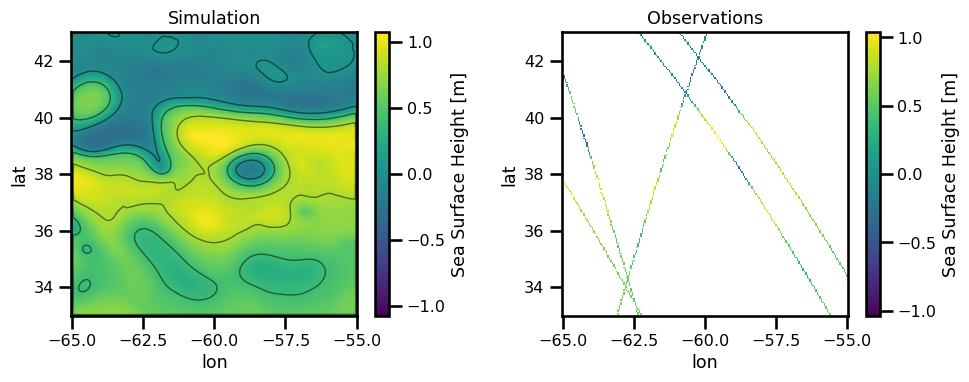

In [78]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

itime = 1
subset_ds = xrds_natl60.ssh.isel(time=itime)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax[0], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_natl60.ssh.min().values, xrds_natl60.ssh.max().values)
subset_ds.plot.contour(
    ax=ax[0], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[0].set(title="Simulation")

# OBSERVATIONS
subset_ds = xrds_obs.ssh_obs.isel(time=itime)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax[1], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_natl60.ssh.min().values, xrds_natl60.ssh.max().values)
subset_ds.plot.contour(
    ax=ax[1], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[1].set(title="Observations")

plt.tight_layout()
plt.show()

In [79]:
dfds = xrds_obs["ssh_obs"].to_dataframe().reset_index().dropna()
# apply coordinate transformation
dfds.head()

,time,lat,lon,ssh_obs
324,0.0,33.05,-58.85,0.6160
525,0.0,33.10,-58.85,0.6066
727,0.0,33.15,-58.80,0.5971
1129,0.0,33.25,-58.80,0.5896
1331,0.0,33.30,-58.75,0.5787


In [80]:
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

scaler = MinMaxDF(columns=["time", "lat", "lon"])

x = scaler.fit_transform(dfds).values
y = dfds[["ssh_obs"]].values

In [81]:
x.shape, y.shape

((1763, 3), (1763, 1))

## Model

In [82]:
from gpjax import Dataset
# import gpjax.kern as jk
import gpjax as gpx
import optax

In [83]:
x[:, 0].min(), x[:, 0].max()

(-1.0, 1.0)

In [84]:
subset = None
rng = np.random.RandomState(123)
# initialize GP
if subset is not None:
    idx = rng.choice(np.arange(x.shape[0]),size=(subset))
        
    D = Dataset(x[idx], y[idx])
else:
     D = Dataset(x, y)

In [85]:
gpx.__version__

'0.6.9'

In [86]:
num_iters = 200
def fit_gp_model(posterior, D, parameter_state=None):
    key = jrandom.PRNGKey(123)
            
    
    negative_mll = jax.jit(gpx.objectives.ConjugateMLL(negative=True))

    negative_mll(posterior, train_data=D)

    optimiser = optax.adam(learning_rate=0.01)

    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=negative_mll,
        train_data=D,
        optim=optimiser,
        num_iters=num_iters,
        safe=True,
        key=key,
    )

    
    return opt_posterior, history

In [87]:
kernel = gpx.RBF(
    active_dims=[0,1,2], 
    lengthscale=jnp.array([6.5801253 , 0.12801293, 0.22265168 ]),
    variance=jnp.array(0.18593845),
)
# kernel = gpx.Matern12(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
# kernel = gpx.Matern32(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
# kernel = gpx.Matern52(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
key = jrandom.PRNGKey(123)

likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=jnp.array(0.00220853))

posterior = prior * likelihood


In [88]:
posterior, history = fit_gp_model(posterior, D)

  0%|          | 0/200 [00:00<?, ?it/s]

In [89]:
lengthscale = posterior.prior.kernel.lengthscale
variance = posterior.prior.kernel.variance
obs_noise = posterior.likelihood.obs_noise

In [91]:
lengthscale, variance, obs_noise

(Array([4.502383  , 0.09367623, 0.24002367], dtype=float32),
 Array(0.12810516, dtype=float32),
 Array(0.00035417, dtype=float32))

### Predictions

In [92]:
def get_grid(da, time):
    lon = da.lon.values
    lat = da.lat.values

    T, X, Y = np.meshgrid(time, lat, lon, indexing="ij")
    T, X, Y = T.ravel(), X.ravel(), Y.ravel()

    return np.stack([T, X, Y], axis=-1)


def create_coord_dataframe(X, y):
    X = np.asarray(X)
    y = np.asarray(y)[:, None]

    data = np.hstack([X, y])

    df = pd.DataFrame(data, columns=["time", "lat", "lon", "ssh"])
    return df

In [94]:
from tqdm.notebook import tqdm
# get grid at current time step
i_step = 1
itime = xrds_obs.time[i_step].values
X_star = get_grid(xrds_natl60, i_step)
X_star = pd.DataFrame(X_star, columns=["time", "lat", "lon"])
X_star = scaler.transform(X_star).values


def predict_batches(X_star):
    out = list()
    for ix in tqdm(np.array_split(X_star, 100, )):
        

        latent_dist = posterior.predict(ix, train_data=D)
        predictive_mean = latent_dist.mean()


        out.append(predictive_mean)

    out = np.hstack(out)

    return out

# predict at current time step
soln = predict_batches(X_star)


  0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
soln_df = create_coord_dataframe(X_star, soln)
soln_df["time"] = itime

In [96]:
soln_df

,time,lat,lon,ssh
0,86400.0,-1.01005,-1.010050,0.449851
1,86400.0,-1.01005,-1.000000,0.467381
2,86400.0,-1.01005,-0.989950,0.484953
3,86400.0,-1.01005,-0.979899,0.502517
4,86400.0,-1.01005,-0.969849,0.520016
...,...,...,...,...
40396,86400.0,1.00000,0.959799,-0.020401
40397,86400.0,1.00000,0.969849,-0.018803
40398,86400.0,1.00000,0.979899,-0.017287
40399,86400.0,1.00000,0.989950,-0.015852


In [97]:
xrds_pred = soln_df.set_index(["time", "lat", "lon"]).to_xarray()

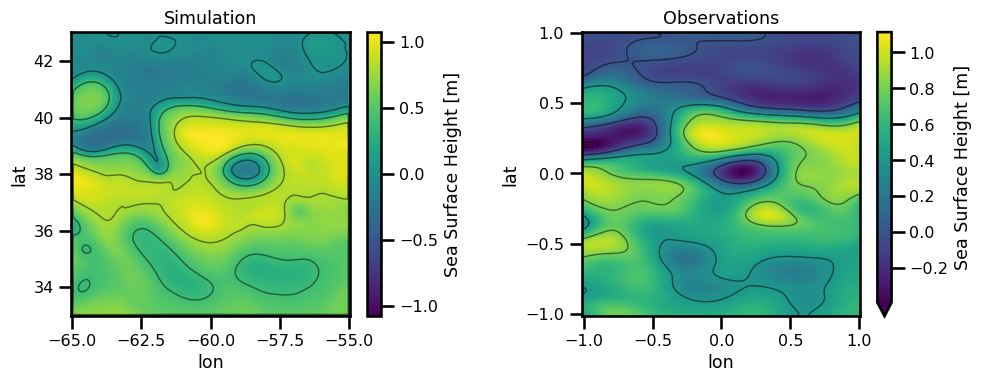

In [98]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

itime = i_step
subset_ds = xrds_natl60.ssh.isel(time=itime)
vmin = xrds_natl60.ssh.min().values
vmax = xrds_natl60.ssh.max().values

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax[0], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_natl60.ssh.min().values, xrds_natl60.ssh.max().values)
subset_ds.plot.contour(
    ax=ax[0], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--"),
    vmin=vmin,vmax=vmax,
    # **kwargs
)

ax[0].set(title="Simulation")

# Predictions
subset_ds = xrds_pred.ssh.isel(time=0)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(
    ax=ax[1], cmap="viridis", cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)


loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_pred.ssh.min().values, xrds_pred.ssh.max().values)

subset_ds.plot.contour(
    ax=ax[1], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--"),
    vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[1].set(title="Observations")

plt.tight_layout()
plt.show()

## Observations - AlongTrack

In [99]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs
# !ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coords/nadirs/

en.nc       g2.nc       j1.nc       swot.nc     tpn.nc
en.nc.dvc   g2.nc.dvc   j1.nc.dvc   swot.nc.dvc tpn.nc.dvc


In [100]:
# Observation Dataset
def preprocess_data(ds):
    
    ds = ds.sortby("time")
    ds = ds.sel(time=slice("2012-10-22",  "2012-10-25"))
    ds = ds.compute()
    ds["lon"] = (ds["lon"] + 180) % 360 - 180
    # fix coords
    ds = ds.where(
        (ds["lat"] >= 33.0) &
        (ds["lat"] <= 43.0) &
        (ds["lon"] >= -65.0) &
        (ds["lon"] <= -55.0),
        drop=True
    )
    ds = ds.sortby("time")
    return ds
xrds_obs = xr.open_mfdataset(
    [
        "/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs/en.nc",
        "/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs/g2.nc",
        "/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs/j1.nc",
        "/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs/tpn.nc",
    ],
    concat_dim="time",
    combine="nested",
    preprocess=preprocess_data, 
)

# xrds_obs = xrds_obs.sel(time=slice("2012-10-22","2012-10-28"))
# xrds_obs = time_rescale(xrds_obs, freq_dt=1, freq_unit="seconds", t0=None)
xrds_obs = xrds_obs.sortby("time")
xrds_obs = time_rescale(xrds_obs, freq_dt=1, freq_unit="seconds", t0=None)
xrds_obs

<xarray.Dataset>
Dimensions:      (time: 2047, cycle: 1)
Coordinates:
  * time         (time) float32 0.0 0.9888 1.978 ... 2.684e+05 2.684e+05
Dimensions without coordinates: cycle
Data variables:
    lat          (time) float32 39.58 39.53 39.47 39.42 ... 42.87 42.92 42.97
    lon          (time) float32 -55.03 -55.06 -55.1 ... -62.44 -62.41 -62.37
    model_index  (time) float32 515.0 515.0 515.0 515.0 ... 590.0 590.0 590.0
    nadir_err    (time) float32 -0.0208 -0.0061 -0.0182 ... -0.0374 -0.0363
    ncycle       (time, cycle) float32 17.4 17.4 17.4 17.4 ... 9.921 9.921 9.921
    ssh_model    (time) float32 0.9958 1.014 1.027 ... -0.0531 -0.0574 -0.0536
    ssh_obs      (time) float32 0.975 1.008 1.009 ... -0.0719 -0.0948 -0.0899
    x_al         (time) float32 1.008e+06 1.008e+06 ... 4.203e+06 4.203e+06

In [101]:
dfds = xrds_obs[["ssh_obs", "lat", "lon"]].to_dataframe().reset_index().dropna()
# apply coordinate transformation
dfds.head()

,time,ssh_obs,lat,lon
0,0.000000,0.9750,39.581959,-55.026276
1,0.988769,1.0077,39.528313,-55.060730
2,1.977539,1.0090,39.474663,-55.095123
3,2.966308,1.0092,39.420998,-55.129425
4,3.955078,1.0119,39.367329,-55.163757


In [102]:
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

scaler = MinMaxDF(columns=["time", "lat", "lon"])

x = scaler.fit_transform(dfds).values
y = dfds[["ssh_obs"]].values

In [103]:
x.shape, y.shape

((2047, 3), (2047, 1))

In [104]:
subset = None
rng = np.random.RandomState(123)
# initialize GP
if subset is not None:
    idx = rng.choice(np.arange(x.shape[0]),size=(subset))
        
    D = Dataset(x[idx], y[idx])
else:
     D = Dataset(x, y)

/Users/eman/miniconda3/envs/jax_gpjax_py311/lib/python3.11/site-packages/gpjax/dataset.py:58: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/eman/miniconda3/envs/jax_gpjax_py311/lib/python3.11/site-packages/gpjax/dataset.py:58: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


In [105]:
kernel = gpx.RBF(
    active_dims=[0,1,2], 
    lengthscale=lengthscale, variance=variance
)
# kernel = gpx.Matern12(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
# kernel = gpx.Matern32(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
# kernel = gpx.Matern52(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
key = jrandom.PRNGKey(123)

likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=obs_noise)

posterior = prior * likelihood


In [106]:
posterior, history = fit_gp_model(posterior, D)

  0%|          | 0/200 [00:00<?, ?it/s]

### Predictions

In [107]:
from tqdm.notebook import tqdm
# get grid at current time step
i_step = 1
itime = xrds_obs.time[i_step].values
X_star = get_grid(xrds_natl60, i_step)
X_star = pd.DataFrame(X_star, columns=["time", "lat", "lon"])
X_star = scaler.transform(X_star).values


def predict_batches(X_star):
    out = list()
    for ix in tqdm(np.array_split(X_star, 100, )):
        

        latent_dist = posterior.predict(ix, train_data=D)
        predictive_mean = latent_dist.mean()


        out.append(predictive_mean)

    out = np.hstack(out)

    return out

# predict at current time step
soln = predict_batches(X_star)


  0%|          | 0/100 [00:00<?, ?it/s]

In [108]:
soln_df = create_coord_dataframe(X_star, soln)
soln_df["time"] = itime

In [109]:
soln_df

,time,lat,lon,ssh
0,0.988769,-1.000552,-1.000880,0.348290
1,0.988769,-1.000552,-0.990868,0.368116
2,0.988769,-1.000552,-0.980856,0.388388
3,0.988769,-1.000552,-0.970844,0.409059
4,0.988769,-1.000552,-0.960832,0.430058
...,...,...,...,...
40396,0.988769,1.000218,0.961462,-0.004292
40397,0.988769,1.000218,0.971473,-0.003837
40398,0.988769,1.000218,0.981485,-0.003429
40399,0.988769,1.000218,0.991497,-0.003064


In [110]:
xrds_pred = soln_df.set_index(["time", "lat", "lon"]).to_xarray()

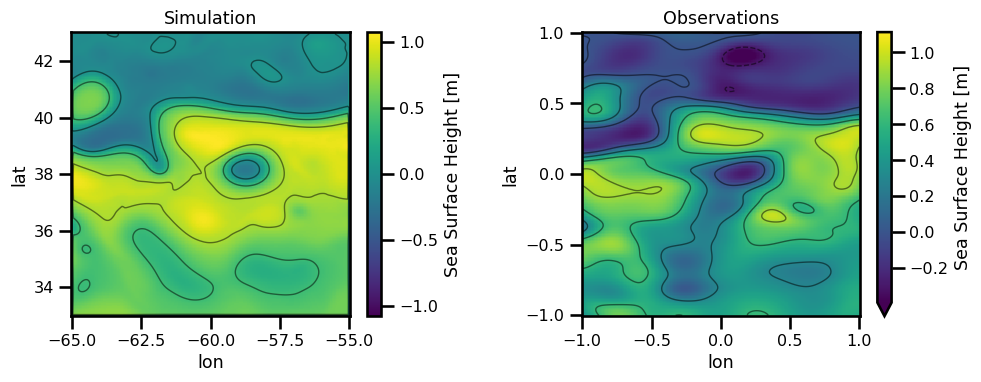

In [111]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

itime = i_step
subset_ds = xrds_natl60.ssh.isel(time=itime)
vmin = xrds_natl60.ssh.min().values
vmax = xrds_natl60.ssh.max().values

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax[0], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_natl60.ssh.min().values, xrds_natl60.ssh.max().values)
subset_ds.plot.contour(
    ax=ax[0], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--"),
    vmin=vmin,vmax=vmax,
    # **kwargs
)

ax[0].set(title="Simulation")

# Predictions
subset_ds = xrds_pred.ssh.isel(time=0)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(
    ax=ax[1], cmap="viridis", cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)


loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds_pred.ssh.min().values, xrds_pred.ssh.max().values)

subset_ds.plot.contour(
    ax=ax[1], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--"),
    vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[1].set(title="Observations")

plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
from tqdm.auto import tqdm, trange

t_buffer = np.timedelta64(7, "D")
ts = xrds.time.values

In [29]:
ts

array([     0.,  86400., 172800., 259200., 345600., 432000., 518400.],
      dtype=float32)

In [28]:
dt = ts[1] - ts[0]

vtime = (xrds.time.values - xrds.time.values[0]) / dt
vts = (ts - ts[0]) / dt

xrds["vtime"] = (("time"), vtime)

xrds

<xarray.Dataset>
Dimensions:  (time: 7, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) float32 0.0 8.64e+04 1.728e+05 ... 4.32e+05 5.184e+05
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vtime    (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0

In [ ]:
lat, lon, time, y = (
    sub.lat.values,
    sub.lon.values,
    sub.vtime.values,
    sub.ssh_obs.values,
)

In [16]:
def init_gp_model(D):
    
    # kernel = gpx.RBF(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
    # kernel = gpx.Matern32(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
    kernel = gpx.Matern52(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
    meanf = gpx.mean_functions.Zero()
    prior = gpx.Prior(mean_function=meanf, kernel=kernel)
    key = jrandom.PRNGKey(123)

    likelihood = gpx.Gaussian(num_datapoints=D.n)

    posterior = prior * likelihood

    return posterior


def fit_gp_model(posterior, D, parameter_state=None):
    key = jrandom.PRNGKey(123)
    
    # if parameter_state is not None:
    #     parameter_state = gpx.intialize(
    #         posterior, key,
    #         kernel=parameter_state["kernel"]
    #     )
    # else:
    #     parameter_state = gpx.initialize(
    #         posterior, key,
    #         kernel={"lengthscale": jnp.array([7.0, 1.0, 1.0])},
    #     )
            
    
    negative_mll = jit(gpx.objectives.ConjugateMLL(negative=True))

    negative_mll(posterior, train_data=D)

    optimiser = optax.adam(learning_rate=0.01)

    # inference_state = gpx.fit(
    #     objective=negative_mll,
    #     parameter_state=param_state,
    #     optax_optim=optimiser,
    #     num_iters=500,
    # )
    


    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=negative_mll,
        train_data=D,
        optim=optimiser,
        num_iters=500,
        safe=True,
        key=key,
    )

    
    return opt_posterior, history


def get_grid(da, time):
    lon = da.lon.values
    lat = da.lat.values

    T, X, Y = np.meshgrid(time, lat, lon, indexing="ij")
    T, X, Y = T.ravel(), X.ravel(), Y.ravel()

    return np.stack([T, X, Y], axis=-1)


def create_coord_dataframe(X, y):
    X = np.asarray(X)
    y = np.asarray(y)[:, None]

    data = np.hstack([X, y])

    df = pd.DataFrame(data, columns=["time", "lat", "lon", "ssh"])
    return df


def predict_batches(X, y):
    return out

In [24]:
xrds

<xarray.Dataset>
Dimensions:  (time: 7, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) float32 0.0 8.64e+04 1.728e+05 ... 4.32e+05 5.184e+05
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vtime    (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0

In [30]:
lat, lon, time, y = (
    xrds.lat.values,
    xrds.lon.values,
    xrds.vtime.values,
    xrds.ssh_obs.values,
)

AttributeError: 'Dataset' object has no attribute 'ssh_obs'

In [19]:
xrda_gp = xr.Dataset()
num_time = len(vts)
params = None
rng = np.random.RandomState(123)
subset = 100

with trange(num_time) as pbar:
    for i in pbar:
        ivt, it = vts[i], ts[i]

        sub = xrds.where(np.abs(xrds.time - it) < t_buffer, drop=True)

        lat, lon, time, y = (
            sub.lat.values,
            sub.lon.values,
            sub.vtime.values,
            sub.ssh_obs.values,
        )

        pbar.set_description(f"Time: {it} | Num Points: {len(lat):,}")

        # create training input vector
        x = np.stack([time, lat, lon], axis=-1)

        # initialize GP
        if subset is not None:
            idx = rng.choice(np.arange(x.shape[0]),size=(subset))
                
            D = Dataset(x[idx], y[idx, None])
        else:
             D = Dataset(x, y[:, None])
        
        
        posterior = init_gp_model(D)

        # get grid at current time step
        X_star = get_grid(xrnatl60, ivt)

        def predict_batches(X_star):
            out = list()
            for ix in np.split(X_star, 10):
                

                latent_dist = posterior.predict(ix, train_data=D)
                predictive_mean = latent_dist.mean()

                out.append(predictive_mean)

            out = np.hstack(out)

            return out

        # predict at current time step
        soln = predict_batches(X_star)

        # create coordinate dataframe
        df = create_coord_dataframe(X_star, soln)
        df["time"] = it

        # append dataset
        xrda_gp = xr.merge(
            [xrda_gp, df.set_index(["time", "lat", "lon"]).to_xarray()],
        )

  0%|          | 0/7 [00:00<?, ?it/s]

UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float32DType'>, <class 'numpy.dtypes.TimeDelta64DType'>) -> None

In [ ]:
xrda_gp

In [ ]:
xrda_gp.to_netcdf("/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/OI/oi_matern52_nadir4.nc")


In [ ]:
xrda_gp.ssh.isel(time=1).plot(cmap="viridis")

In [ ]:
xrnatl60["ssh_gp"] = xrda_gp.ssh

In [ ]:
xrnatl60

In [ ]:
%matplotlib inline

itime = 10

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

vmin = np.min([xrnatl60.sossheig.min(), xrnatl60.ssh_gp.min()])
vmax = np.min([xrnatl60.sossheig.max(), xrnatl60.ssh_gp.max()])

xrnatl60.sossheig.sel(time="2012-11-01").plot.pcolormesh(
    ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[0].set(title="Original")

xrnatl60.ssh_gp.sel(time="2012-11-01").plot.pcolormesh(
    ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[1].set(title="Naive Gaussian Process")

plt.tight_layout()
plt.show()

In [133]:
import common_utils as cutils

In [134]:
ds_rff = cutils.calculate_physical_quantities(xrnatl60.ssh_gp)
ds_natl60 = cutils.calculate_physical_quantities(xrnatl60.sossheig)

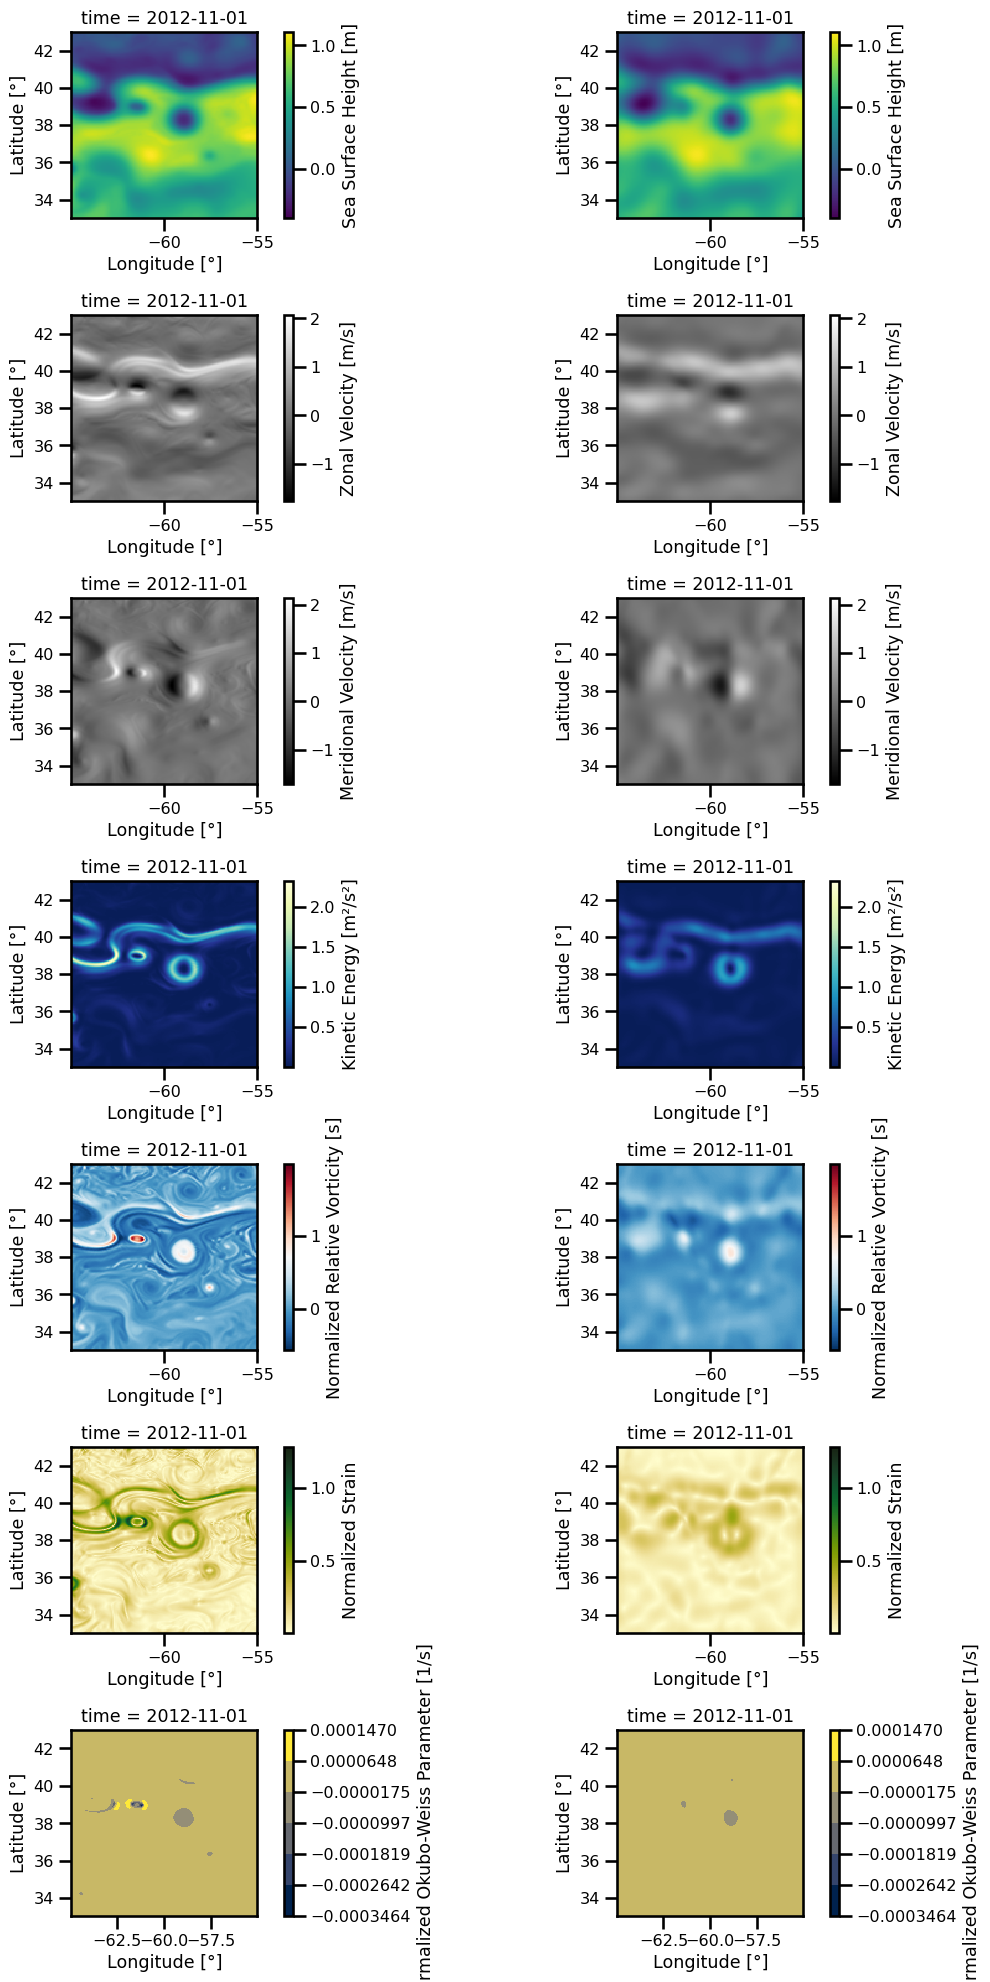

In [135]:
fig, ax = cutils.plot_analysis_vars(
    [
        ds_natl60.sel(time="2012-11-01"),
        ds_rff.sel(time="2012-11-01"),
    ]
)
plt.show()

In [136]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rff = cutils.calculate_isotropic_psd(ds_rff)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

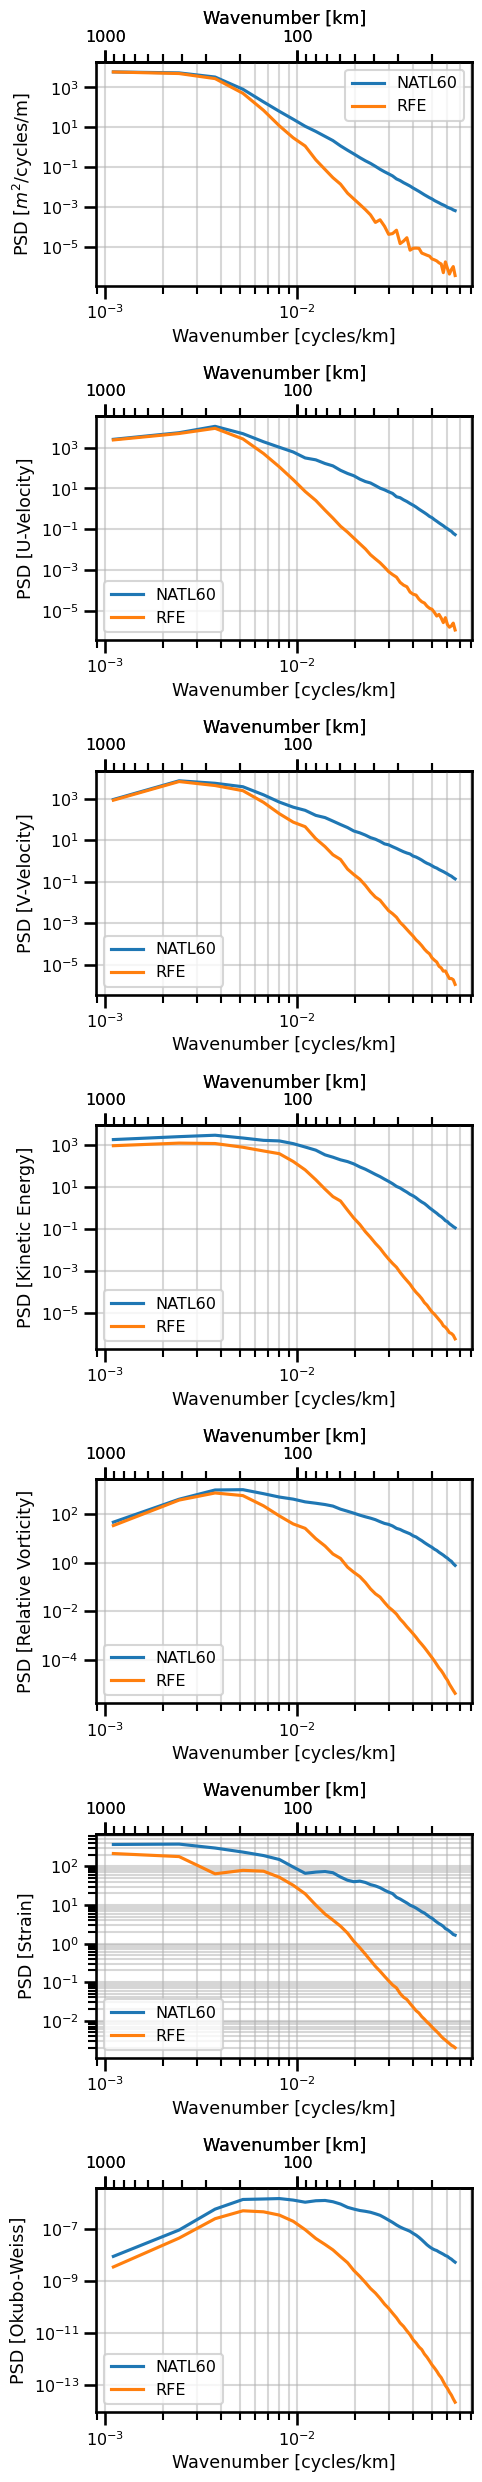

In [114]:
fig, ax = cutils.plot_analysis_psd_iso(
    [
        ds_psd_natl60,
        ds_psd_rff,
    ],
    [
        "NATL60",
        "RFE",
    ],
)
plt.show()

In [115]:
ds_scores = cutils.calculate_isotropic_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


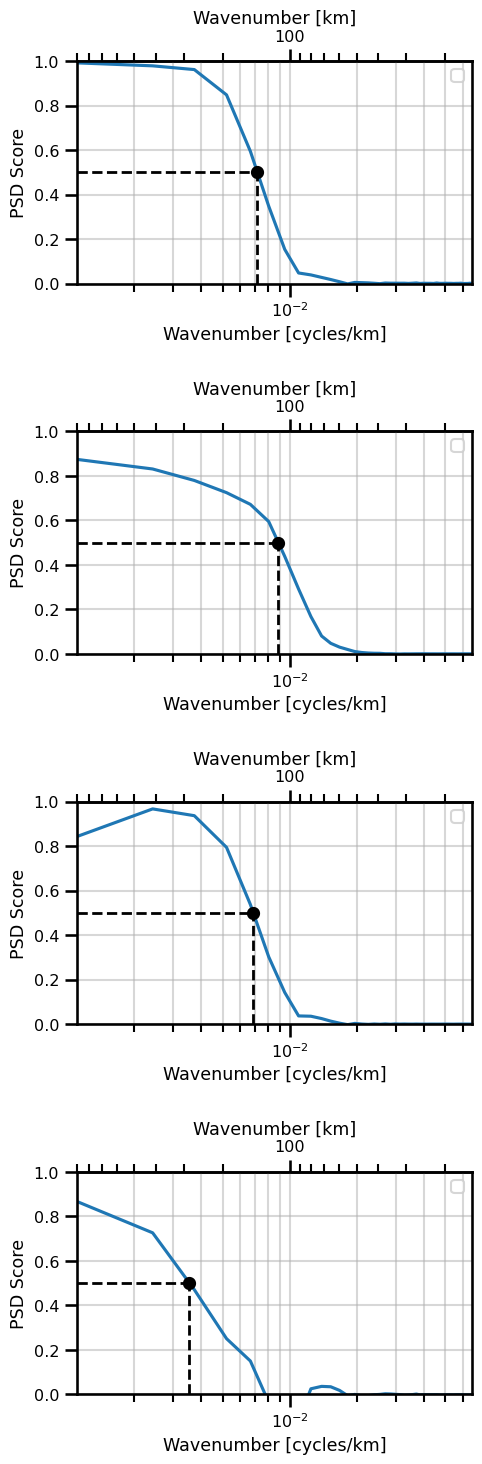

In [116]:
cutils.plot_analysis_psd_iso_score([ds_scores], ["RFE"], ["k"])
plt.show()

In [117]:
ds_psd_natl60 = cutils.calculate_spacetime_psd(ds_natl60)
ds_psd_rff = cutils.calculate_spacetime_psd(ds_rff)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

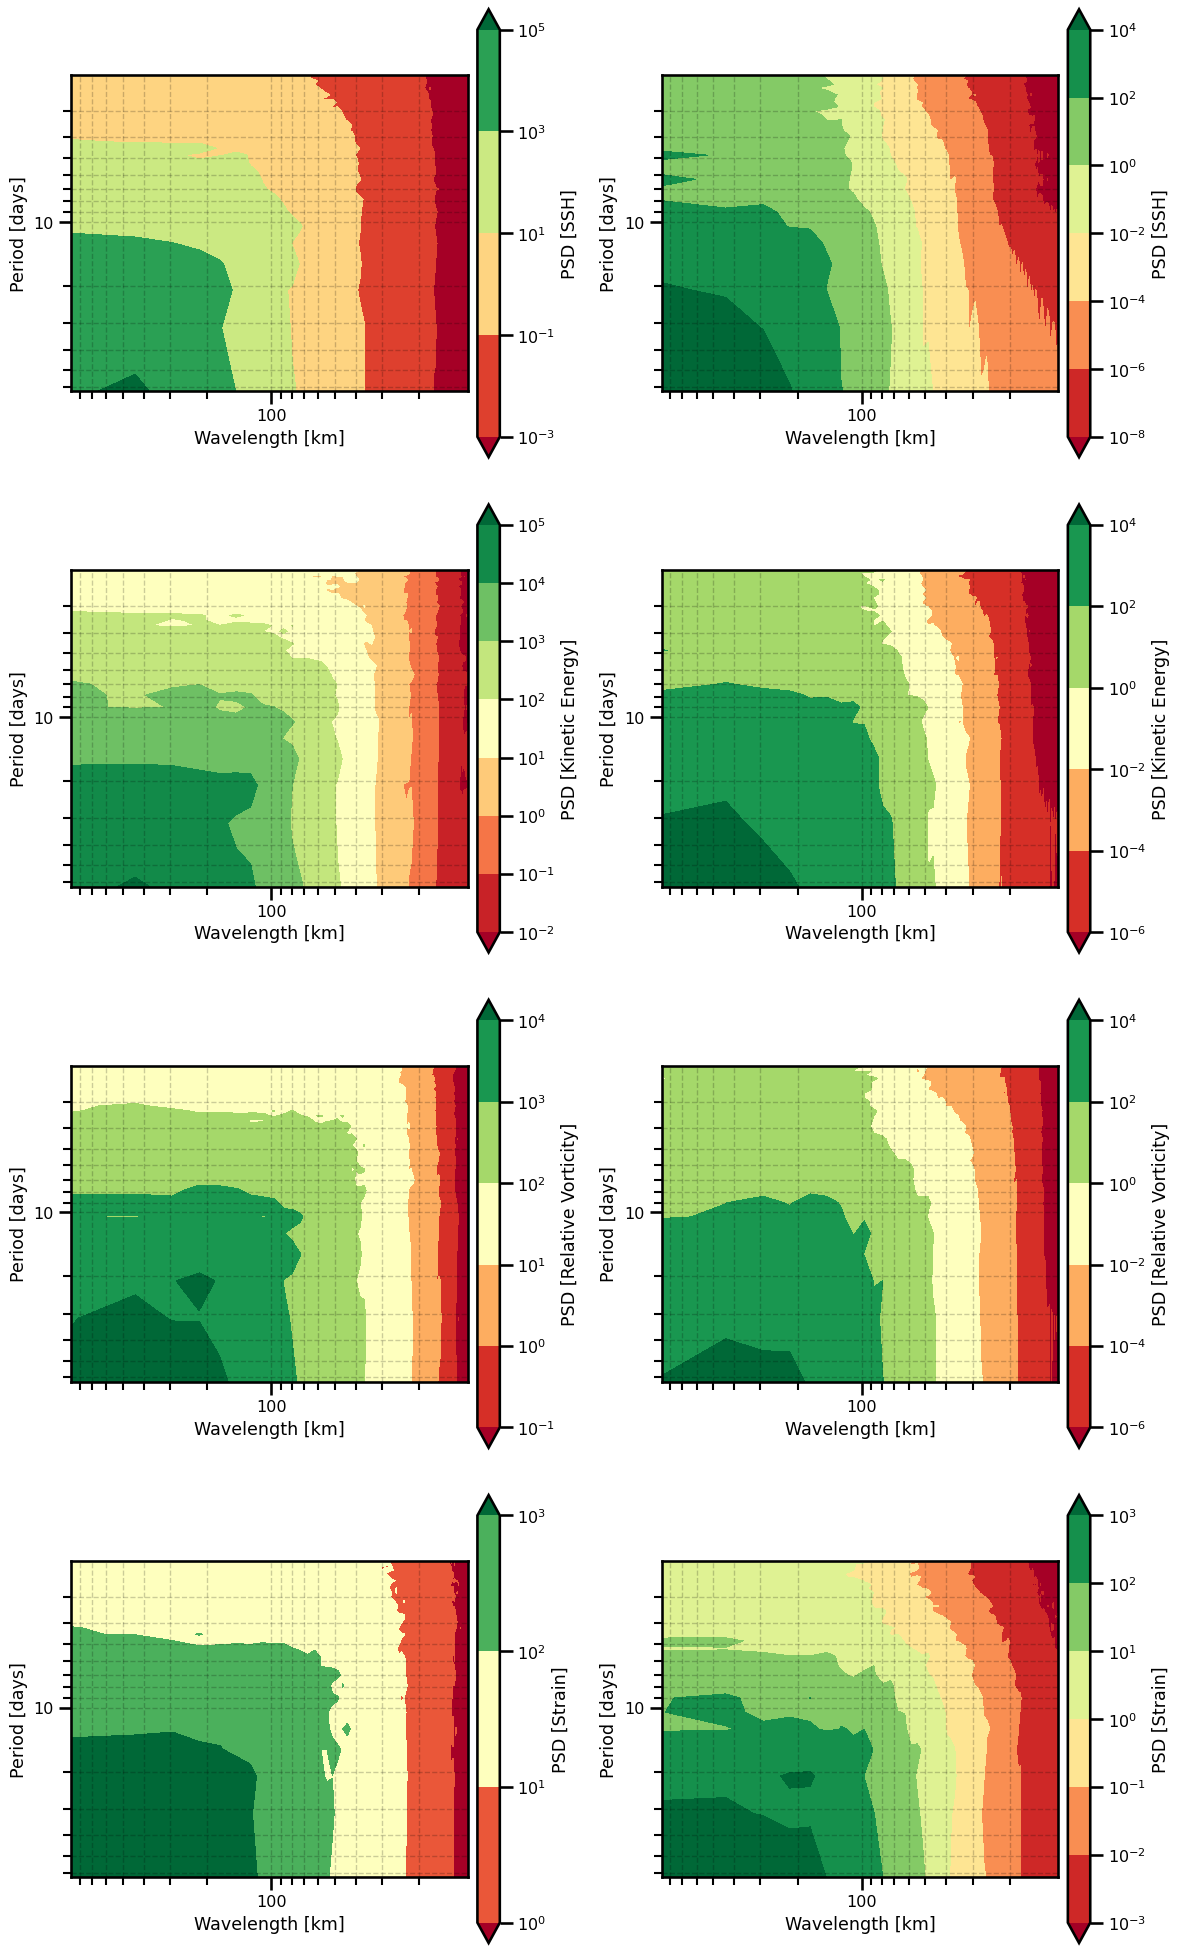

In [118]:
fig, ax = cutils.plot_analysis_psd_spacetime(
    [
        ds_psd_natl60,
        ds_psd_rff,
    ],
    [
        "NATL60",
        "RFE",
    ],
)
plt.show()

In [119]:
ds_psd_rff = cutils.calculate_spacetime_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

In [120]:
for ivar in ds_psd_rff:
    resolved_spatial_scale = ds_psd_rff[ivar].attrs["resolved_scale_space"] / 1e3
    print(f"Resolved Scale [km]: {resolved_spatial_scale:.2f} [{ivar.upper()}]")
    resolved_temporal_scale = ds_psd_rff[ivar].attrs["resolved_scale_time"]
    print(f"Resolved Scale [days]: {resolved_temporal_scale:.2f}  [{ivar.upper()}]")

Resolved Scale [km]: 132.99 [SSH]
Resolved Scale [days]: 12.26  [SSH]
Resolved Scale [km]: 99.38 [KE]
Resolved Scale [days]: 15.58  [KE]
Resolved Scale [km]: 153.76 [VORT_R]
Resolved Scale [days]: 14.57  [VORT_R]
Resolved Scale [km]: 231.09 [STRAIN]
Resolved Scale [days]: 50.80  [STRAIN]


In [ ]:
_ = cutils.plot_analysis_psd_spacetime_score([ds_psd_rff], ["rff"])